In [0]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6


In [0]:
# Imports
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import difflib
import operator
import math
%matplotlib inline

In [0]:
# Import data
url_nodes = 'https://raw.githubusercontent.com/cpenalozag/SocialNetworksData/master/CalidadAgua/nodes.csv'
nodeData = pd.read_csv(url_nodes)

url_edges = 'https://raw.githubusercontent.com/cpenalozag/SocialNetworksData/master/CalidadAgua/edges.csv'
edges = pd.read_csv(url_edges)

In [3]:
from scipy import stats
nodeData['z'] = np.abs(stats.zscore(nodeData['poblacion']))

# Names of municipalities with largest populations and low/no risk
names = []
max_p = 0

for index, row in nodeData.iterrows():
  if row['z'] >= 1:
    if row['riesgo'] in['SIN RIESGO', 'BAJO', 'MEDIO']:
      names.append(row['municipio'])
    else:
      max_p = max(max_p, int(row['poblacion']))
    print(row['municipio'], row['poblacion'], row['riesgo'])

# Normalize by largest population with high risk (max_p)
nodeData['population_factor'] = nodeData['poblacion'] / max_p

# Replace values more than 1 (for municipalities in names )
for index, row in nodeData.iterrows():
  if row['population_factor'] > 1:
    nodeData.set_value(index,'population_factor',1)

# Normalize to 0.6 - 1: avoid values close to 0 for small municipalities
p_scaler = MinMaxScaler(feature_range=(0.6, 1))
nodeData['population_factor'] = p_scaler.fit_transform(nodeData[['population_factor']])
print(names)
print(max_p)
nodeData.head()

Bello 455807 SIN RIESGO
Medellín 2464322 SIN RIESGO
Barranquilla 1218737 SIN RIESGO
Soledad 615349 SIN RIESGO
Bogotá DC 7878783 BAJO
Manizales 396102 ALTO
Valledupar 453205 SIN RIESGO
Montería 441260 SIN RIESGO
Soacha 511262 SIN RIESGO
Neiva 342221 MEDIO
Santa Marta 483722 SIN RIESGO
Villavicencio 484429 MEDIO
Pasto 440040 MEDIO
Cúcuta 649983 SIN RIESGO
Pereira 469644 BAJO
Bucaramanga 527985 SIN RIESGO
Ibagué 553526 ALTO
Buenaventura 399619 BAJO
Cali 2369829 SIN RIESGO
['Bello', 'Medellín', 'Barranquilla', 'Soledad', 'Bogotá DC', 'Valledupar', 'Montería', 'Soacha', 'Neiva', 'Santa Marta', 'Villavicencio', 'Pasto', 'Cúcuta', 'Pereira', 'Bucaramanga', 'Buenaventura', 'Cali']
553526


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


,municipio,departamento,lat,lon,poblacion,riesgo,z,population_factor
0,Abejorral,Antioquia,5.791430,-75.427038,19290,SIN RIESGO,0.094783,0.613169
1,Abriaquí,Antioquia,6.628489,-76.083530,2128,SIN RIESGO,0.154143,0.600742
2,Alejandría,Antioquia,6.355780,-75.098662,4992,SIN RIESGO,0.144237,0.602816
3,Amagá,Antioquia,6.035817,-75.700911,29555,SIN RIESGO,0.059278,0.620602
4,Amalfi,Antioquia,7.020400,-74.950476,22088,SIN RIESGO,0.085105,0.615195


In [4]:
nodes = {}

# Fill node dictionary
for index, row in nodeData.iterrows():
    nodes[row['municipio']]={"lat": row["lat"], "lon": row["lon"],"poblacion": float(row["poblacion"]), "population_factor": float(row["population_factor"]),"riesgo": row["riesgo"]}

edges.head()

,source,target,weight
0,Abejorral,Alejandría,72
1,Abejorral,Amagá,40
2,Abejorral,Andes,60
3,Abejorral,Angelópolis,49
4,Abejorral,Anza,79


In [5]:
# Weight is distance, find inverse so closest municipalities have higher weights
edges['weight'] = np.where((edges.weight > 0), 1/edges.weight, edges.weight)
d_scaler = MinMaxScaler(feature_range=(0.1, 1))
edges['weight'] = d_scaler.fit_transform(edges[['weight']])
edges.describe()

,weight
count,35231.000000
mean,0.119677
std,0.019360
min,0.100000
25%,0.110843
50%,0.113846
75%,0.120455
max,1.000000


In [0]:
# Create Graph object
G = nx.DiGraph()

# Assign risk factor
def risk_factor(risk_origin):
  if risk_origin == 'SIN RIESGO':
    return 0
  elif risk_origin == 'BAJO':
    return 0.1
  elif risk_origin == 'MEDIO':
    return 0.6
  elif risk_origin == 'ALTO':
    return 0.9
  elif risk_origin == 'INVIABLE SANITARIAMENTE':
    return 1

# Add nodes
for n in nodes:
  G.add_node(n,**nodes[n])

# Add edges
for e in range(len(edges)):
  n1 = edges['source'][e]
  n2 = edges['target'][e]
  risk_n1 = G.nodes[n1]['riesgo']
  risk_n2 = G.nodes[n2]['riesgo']
  pf_n1 = G.nodes[n1]['population_factor']
  pf_n2 = G.nodes[n2]['population_factor']
  w = edges['weight'][e]

  G.add_edge(n2, n1, weight = w * risk_factor(risk_n1) * pf_n2)
  G.add_edge(n1, n2, weight = w * risk_factor(risk_n2) * pf_n1)

In [7]:
w_scaler = MinMaxScaler(feature_range=(0, 2))


weights = [G[u][v]['weight'] for u,v in G.edges()]
w_df = pd.DataFrame(weights)
w_df.columns = ['weight']
w_df['weight'] = w_scaler.fit_transform(w_df[['weight']])
weights = list(w_df['weight'])
w_df.describe()

,weight
count,70462.000000
mean,0.115250
std,0.104770
min,0.000000
25%,0.000000
50%,0.146907
75%,0.219622
max,2.000000


In [0]:
m = Basemap(
        projection='merc',
        llcrnrlat=-5,urcrnrlat=13,
        llcrnrlon=-80,urcrnrlon=-67,
        lat_ts=20,resolution='i')

mx, my = m([i for i in nx.get_node_attributes(G,'lon').values()], [i for i in nx.get_node_attributes(G,'lat').values()])
pos = {}

for index, key in enumerate(nodes):
  pos[key] = (mx[index], my[index])

<Figure size 432x288 with 0 Axes>

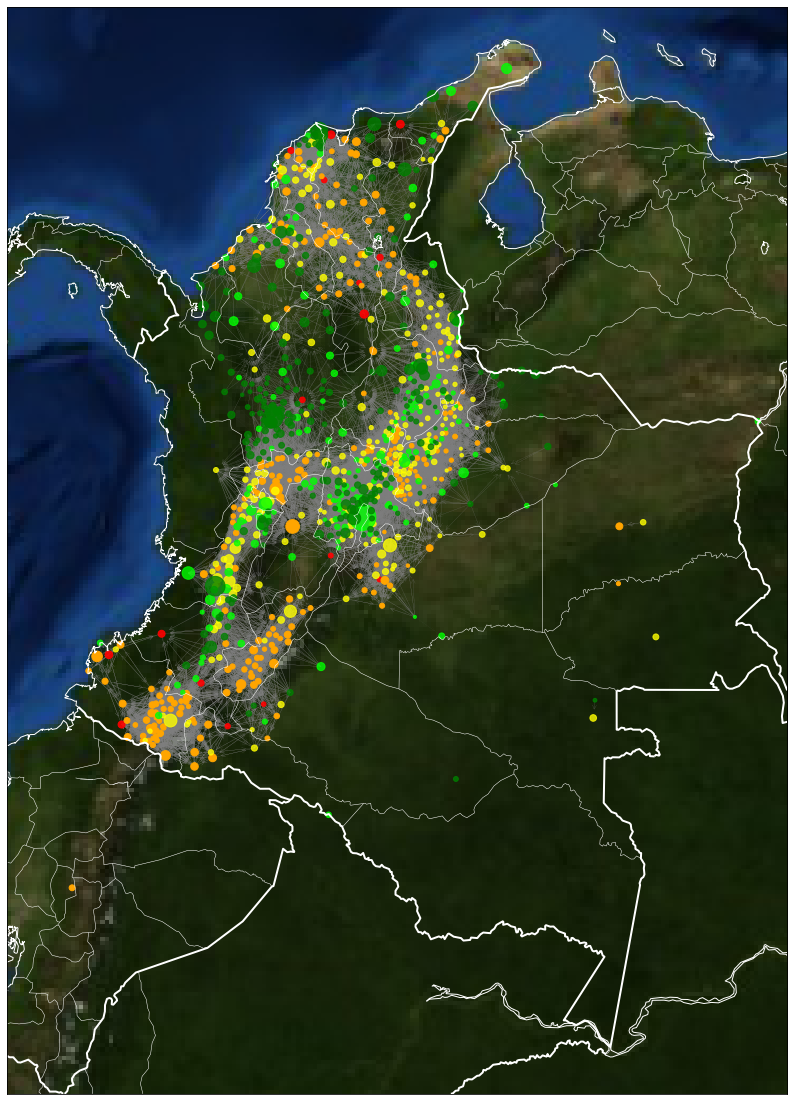

In [17]:
# Draw the network
plt.tight_layout()
fig = plt.figure(figsize=(30,20))

# Number of nodes with names
num = 10
# Inviable
inv = 'INVIABLE SANITARIAMENTE'

nx.draw_networkx_nodes(G, pos, 
                       node_size = [math.sqrt(G.nodes[g]['poblacion'])/3 for g in G.nodes() if G.nodes[g]['riesgo']==inv],
                       nodelist = [g for g in G.nodes() if G.nodes[g]['riesgo']==inv ],
                       node_color = 'red', alpha = 0.9)

# Alto

nx.draw_networkx_nodes(G, pos, 
                       node_size = [math.sqrt(G.nodes[g]['poblacion'])/4 for g in G.nodes() if G.nodes[g]['riesgo']=='ALTO'],
                       nodelist = [g for g in G.nodes() if G.nodes[g]['riesgo']=='ALTO' ],
                       node_color = 'orange', alpha = 1)

# Medio
nx.draw_networkx_nodes(G, pos, 
                       node_size = [math.sqrt(G.nodes[g]['poblacion'])/4 for g in G.nodes() if G.nodes[g]['riesgo']=='MEDIO'],
                       nodelist = [g for g in G.nodes() if G.nodes[g]['riesgo']=='MEDIO' ],
                       node_color = 'yellow', alpha = 0.8)

# Bajo

nx.draw_networkx_nodes(G, pos, 
                       node_size = [math.sqrt(G.nodes[g]['poblacion'])/4 for g in G.nodes() if G.nodes[g]['riesgo']=='BAJO'],
                       nodelist = [g for g in G.nodes() if G.nodes[g]['riesgo']=='BAJO' ],
                       node_color = 'lime', alpha = 0.8)

# Sin riesgo

nx.draw_networkx_nodes(G, pos, 
                       node_size = [math.sqrt(G.nodes[g]['poblacion'])/4 for g in G.nodes() if G.nodes[g]['riesgo']=='SIN RIESGO'],
                       nodelist = [g for g in G.nodes() if G.nodes[g]['riesgo']=='SIN RIESGO' ],
                       node_color = 'g', alpha = 0.8)

labels = ['Ibagué', 'Cisneros', 'Boyacá', 'Garzón',
          'Pasto', 'Neiva', 'Dagua', 'Granada']

#nx.draw_networkx_labels(G, pos, font_size=22, alpha=0.75, font_weight='bold',font_color='white', labels = {x:x for x in G.nodes() if x in labels})
#nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold',font_color='0.75', labels = {x:x for x in G.nodes() if G.nodes[x]['riesgo'] in ['SIN RIESGO','BAJO'] and G.nodes[x]['poblacion']>250000})



#nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold',font_color='yellow', labels = {x:x for x in G.nodes() if G.nodes[x]['riesgo'] in ['ALTO'] and G.nodes[x]['poblacion']>20000})

nx.draw_networkx_edges(G, pos, edge_color='grey', arrowstyle='->', arrowsize=10, width=weights)
m.drawcountries(color='white', linewidth=2)
m.drawcoastlines(color='white')
m.bluemarble(scale=1)
m.drawstates(color='white')

In [0]:
len(list(G.nodes(data=True)))
nx.write_graphml(G, 'calidad_agua.graphml')

In [0]:
#Clustering promedio
print("Clustering promedio")
print(nx.average_clustering(G))

Clustering promedio
0.6927716955967018


Grado máximo:  172
Grado mínimo:  0
Grado promedio:  74.95531914893617
Mediana del grado:  62.0


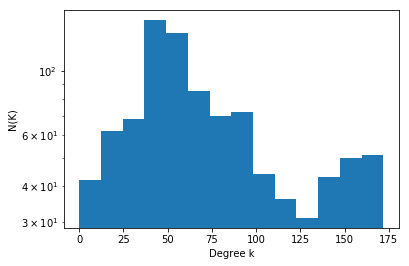

In [0]:
# Grado promedio
deg=[]
for node in G.nodes():
    deg.append(G.degree(node))
 
    
print('Grado máximo: ', max(deg))
print('Grado mínimo: ', min(deg))
print('Grado promedio: ', np.mean(deg))
print('Mediana del grado: ', np.median(deg))

plt.hist(deg, bins='auto',log=True)
plt.xlabel("Degree k")
plt.ylabel("N(K)")
plt.show()

In [0]:
# Estadísticas descriptivas
riesgos = [G.nodes[entry]['riesgo'] for entry in dict(G.nodes(data=True))]
poblacion = [G.nodes[entry]['poblacion'] for entry in dict(G.nodes(data=True))]

df = pd.DataFrame(list(zip(riesgos, poblacion)), columns =['Riesgo', 'Población']) 
df.describe(include = 'all')

,Población
count,9.400000e+02
mean,4.669339e+04
std,2.892710e+05
min,1.103000e+03
25%,6.968250e+03
50%,1.367550e+04
75%,2.828700e+04
max,7.878783e+06


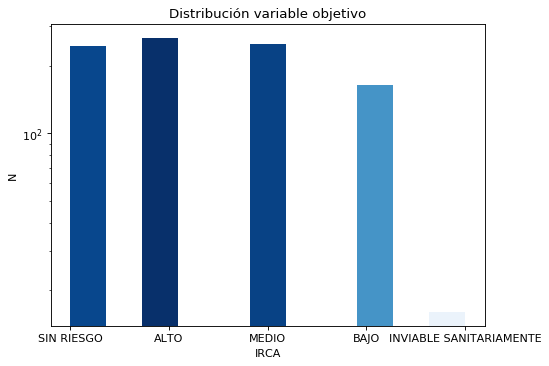

In [0]:
# Riesgo
from matplotlib import colors
def plot_hist():
    plt.figure(num=None, figsize=(7, 5), dpi=80, facecolor='w', edgecolor='k')
    N, bins, patches = plt.hist(riesgos, bins = "auto", log = True)
    
    # Color code by height
    fracs = N / N.max()

    # we need to normalize the data to 0..1 for the full range of the colormap
    norm = colors.Normalize(fracs.min(), fracs.max())

    # Now, we'll loop through our objects and set the color of each accordingly
    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.Blues(norm(thisfrac))
        thispatch.set_facecolor(color)

    plt.title('Distribución variable objetivo')
    plt.xlabel('IRCA')
    plt.ylabel('N')
    plt.show()

plot_hist()

## Centralidad

In [0]:
degree_centrality = nx.out_degree_centrality(G)

for indice, municipio in enumerate(sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]):
  print(indice+1, municipio[0], municipio[1],  'Riesgo:',G.nodes[municipio[0]]['riesgo'], 'Población:', G.nodes[municipio[0]]['poblacion'])

1 Paipa 0.18317358892438768 Riesgo: SIN RIESGO Población: 30740.0
2 Sotaquirá 0.1810436634717785 Riesgo: ALTO Población: 7709.0
3 Tuta 0.1810436634717785 Riesgo: BAJO Población: 9673.0
4 Cómbita 0.17997870074547392 Riesgo: BAJO Población: 7957.0
5 Motavita 0.17997870074547392 Riesgo: BAJO Población: 8067.0


In [0]:
ev_centrality=nx.eigenvector_centrality(G,max_iter=1000, weight='weight') # compute eigenvector centrality

for indice, municipio in enumerate(sorted(ev_centrality.items(), key=lambda x: x[1], reverse=True)[:20]):
  print(indice+1, municipio[0], municipio[1],  'Riesgo:',G.nodes[municipio[0]]['riesgo'], 'Población:', G.nodes[municipio[0]]['poblacion'])

1 Cucaita 0.14239132267055543 Riesgo: ALTO Población: 4687.0
2 Sotaquirá 0.14223380332582805 Riesgo: ALTO Población: 7709.0
3 Toca 0.14201422027595362 Riesgo: ALTO Población: 10157.0
4 Boyacá 0.13968175090668317 Riesgo: ALTO Población: 10099.0
5 Ciénega 0.1390665575558343 Riesgo: ALTO Población: 4754.0
6 Sáchica 0.13822627579858202 Riesgo: ALTO Población: 3791.0
7 Rondón 0.13656780453897713 Riesgo: ALTO Población: 2822.0
8 Gachantivá 0.1361261234236721 Riesgo: ALTO Población: 2654.0
9 Pesca 0.1354493892163235 Riesgo: ALTO Población: 8032.0
10 Turmequé 0.13399066973523585 Riesgo: ALTO Población: 6182.0
11 Santa Sofía 0.13332882304784668 Riesgo: ALTO Población: 2704.0
12 Ráquira 0.13272235664100246 Riesgo: ALTO Población: 13588.0
13 Sutamarchán 0.1321883138463278 Riesgo: ALTO Población: 5916.0
14 Chinavita 0.129866013764245 Riesgo: ALTO Población: 3528.0
15 Zetaquira 0.12984998444601478 Riesgo: ALTO Población: 4557.0
16 Umbita 0.12862663903033045 Riesgo: ALTO Población: 10314.0
17 Tota 0

In [0]:
closeness_centrality = nx.closeness_centrality(G)

for indice, municipio in enumerate(sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]):
  print(indice+1, municipio[0], municipio[1], 'Riesgo:',G.nodes[municipio[0]]['riesgo'], 'Población:', G.nodes[municipio[0]]['poblacion'])

1 Yacopí 0.28563652758859726 Riesgo: MEDIO Población: 16951.0
2 San Pablo De Borbur 0.281584945636986 Riesgo: MEDIO Población: 10524.0
3 La Dorada 0.28089202666894664 Riesgo: MEDIO Población: 76963.0
4 Norcasia 0.2805468444549141 Riesgo: ALTO Población: 6374.0
5 Muzo 0.2804606814191479 Riesgo: MEDIO Población: 9040.0


In [0]:
G.nodes['Villavieja']['poblacion']

7314.0

In [0]:
h,a = nx.hits(G)

In [19]:
# Top authorities

for indice, municipio in enumerate(sorted(a.items(), key=lambda x: x[1], reverse=True)[:10]):
  print(indice+1, municipio[0], municipio[1], 'Riesgo:',G.nodes[municipio[0]]['riesgo'], 'Población:', G.nodes[municipio[0]]['poblacion'])

1 Cucaita 0.012593618507146612 Riesgo: ALTO Población: 4687.0
2 Sáchica 0.012137263844965555 Riesgo: ALTO Población: 3791.0
3 Boyacá 0.012131919772279615 Riesgo: ALTO Población: 10099.0
4 Ciénega 0.01177688419021155 Riesgo: ALTO Población: 4754.0
5 Sutamarchán 0.011756705659130054 Riesgo: ALTO Población: 5916.0
6 Ráquira 0.011747616769712003 Riesgo: ALTO Población: 13588.0
7 Turmequé 0.011650829130048852 Riesgo: ALTO Población: 6182.0
8 Santa Sofía 0.011590832175714097 Riesgo: ALTO Población: 2704.0
9 Gachantivá 0.011539558834809102 Riesgo: ALTO Población: 2654.0
10 Toca 0.011484333898464979 Riesgo: ALTO Población: 10157.0
